When thinking in Foundational Models we should think on a model trained on generic visual patterns that can be transferred to new tasks without task-specific training. In Earth Observation (EO) it means, it doesnt know about land cover, physics, vegetation types. It only know textures, shapes, contrast. IT is powerful but dangerous.

SAM is zero-shot ; object agnostic ; scale-agnostic ; spectrally blind. Therefore, it creates the perfect tension: it segments beautifully, but it understands nothing environmentally. It segment baesd on texture/shape/contrast alone ignoring spectal signatures (NDVI for vegetation) or physical context (reef vs sandbar distinction in turbid water)

Concept: The Segment Anything Model (SAM) has "seen" 11 billion images, but it doesn't know what a "tree" is. It only knows what an "object" is (texture, edge, contrast).

In this practical we use foundation models as analysis tools, not as models to be trained, therefore no GPU is required.

Instead of loading a downloaded image lets swithc to cloud straming keeping the same areas Hulhudhoo Maldives for coastal/reef segmentation; and Hyde Park/London for urban green space. 

LEts use pystac-client + planetary_computer + stackstac (already in the container)

Do these polygons correspond to meaningful geographic objects?

Could you calculate area from these?

Would a policymaker trust these shapes?
SAM Porposes objects, We test whether those objects are environmentally meaningful.

Data

Tile-based RGB imagery (leafmap basemap)

Two contrasting environments:

Hyde Park (urban green space)

Hulhudhoo, Maldives (reef / lagoon system)

No STAC. No spectral bands. This is intentional.

Part A — Spatial framing (before any model)

Task A1

Display the study area on a map.

Draw or define an AOI.

Answer (Markdown, short paragraph):

What environmental processes dominate this area?
(e.g. vegetation structure, water depth, urban materials, shadows)

Why this matters
Students must define the question before running a model.

Part B — What the model sees

Task B1

Download a small RGB image for the AOI.

Visualise it.

Answer:

What objects are visually distinct?

What boundaries are ambiguous?

What information is missing?

(Students should mention no spectral, no physics, no depth.)

In [ ]:
import leafmap
import os
from samgeo import SamGeo
import pystac_client
import planetary_computer
import rioxarray

In [2]:
# Bounding boxes (W, S, E, N) in lon/lat (EPSG:4326)

AOI = {
    "Hulhudhoo_Maldives": (73.20, 3.82, 73.26, 3.88),
    "HydePark_London": (-0.19, 51.50, -0.15, 51.52),
}

AOI


{'Hulhudhoo_Maldives': (73.2, 3.82, 73.26, 3.88),
 'HydePark_London': (-0.19, 51.5, -0.15, 51.52)}

In [5]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

print("Connected to Planetary Computer STAC")


Connected to Planetary Computer STAC


In [6]:
site = "HydePark_London"
bbox = AOI[site]

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2021-04-01/2021-05-15",
    query={"eo:cloud_cover": {"lt": 10}},
)

items = list(search.get_items())
len(items)


2

In [7]:
item = items[0]
item.id, item.datetime, item.properties.get("eo:cloud_cover")


('S2B_MSIL2A_20210423T105619_R094_T30UXC_20210525T005413',
 datetime.datetime(2021, 4, 23, 10, 56, 19, 24000, tzinfo=tzutc()),
 1.047312)

In [11]:
import folium

# Map centered on Hyde Park
m = folium.Map(location=[51.51, -0.17], zoom_start=14, tiles="OpenStreetMap")

# AOI bbox = (W, S, E, N)
west, south, east, north = bbox

# Draw AOI rectangle
folium.Rectangle(
    bounds=[(south, west), (north, east)],
    color="yellow",
    fill=False,
    weight=3,
).add_to(m)

# Draw STAC item footprint (GeoJSON)
folium.GeoJson(
    data=item.geometry,
    name="Sentinel-2 scene footprint",
).add_to(m)

folium.LayerControl().add_to(m)
m


A foundation model can segment anything — but understands nothing about Earth systems.

In [1]:
import os
import leafmap.foliumap as leafmap  # stable inside containers
from samgeo import SamGeo
from samgeo.common import tms_to_geotiff


### PART A

#### DEFINE STUDY AREA

In Earth Observation, where you look matters as much as what you do.

Hyde Park represents an urban green space embedded in infrastructure.
Hulhudhoo represents a coastal reef–lagoon system driven by natural processes.

We will use the same model on both — and observe what changes.

In [2]:
SITE = "HydePark"   # change to "Hulhudhoo" later

AOI_DEFAULT = {
    "HydePark": [-0.19, 51.50, -0.15, 51.52],       # [W, S, E, N]
    "Hulhudhoo": [73.215, 3.835, 73.255, 3.875],    # [W, S, E, N]
}

bbox = AOI_DEFAULT[SITE]
bbox


[-0.19, 51.5, -0.15, 51.52]

Student Questions:

What dominant land-cover types do you expect in this AOI?

What spatial patterns matter here (edges, textures, context)?

Which features are environmental rather than visual?

### PART B

#### Foundational model segmentation (SAM as a blind observer)

SAM is a foundation vision model trained on generic images.

t is:

zero-shot

object-agnostic

scale-agnostic

spectrally blind

It sees shapes, contrast, and texture — not vegetation, water, or land use.

#### Interactive map

In [3]:
import leafmap.foliumap as leafmap

m = leafmap.Map(center=[51.51, -0.17], zoom=16)
m.add_basemap("SATELLITE")
m


#### Download a small GeoTiff (CPU-safe)

In [4]:
import os, urllib.request

ckpt_dir = os.path.expanduser("~/.cache/torch/hub/checkpoints")
os.makedirs(ckpt_dir, exist_ok=True)

ckpt_path = os.path.join(ckpt_dir, "sam_vit_b_01ec64.pth")
url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"

if not os.path.exists(ckpt_path):
    print("Downloading SAM checkpoint...")
    urllib.request.urlretrieve(url, ckpt_path)
    print("Saved to:", ckpt_path)
else:
    print("Checkpoint already exists:", ckpt_path)


Checkpoint already exists: /home/vscode/.cache/torch/hub/checkpoints/sam_vit_b_01ec64.pth


In [5]:
out_dir = "data/week3"
os.makedirs(out_dir, exist_ok=True)

image = os.path.join(out_dir, f"{SITE}_satellite.tif")

# zoom controls resolution & file size (17–18 is usually fine; 19 can get heavy)
tms_to_geotiff(
    output=image,
    bbox=bbox,
    zoom=16,
    source="Satellite",   # uses an online basemap
)

image


The output file data/week3/HydePark_satellite.tif already exists. Use `overwrite=True` to overwrite it.


'data/week3/HydePark_satellite.tif'

What is the approximate spatial resolution implied by the zoom level?

Is this image “true colour”? If not, what does that imply?

(Hint: many basemaps are RGB composites with unknown processing.)

#### PART C

In [6]:
import os
print("GeoTIFF size (MB):", round(os.path.getsize(image)/1e6, 2))


GeoTIFF size (MB): 23.36


#### Run SAM (zero-shot)

SAM is zero-shot segmentation. "Zero-Shot" means "No Training Required."
It produces masks that look correct, but it does not know what they represent environmentally.

We use CPU mode and small images, so it runs locally.

In [9]:
from samgeo import SamGeo


In the past (Supervised Learning), if you wanted to find trees in Hyde Park, you had to:

Download 50 images.

Hand-draw 500 polygons around trees.

Train a model for 3 hours.

Run it.


What we are doing right now IS Zero-Shot:

Download 1 image of Hyde Park.

Load SAM (which has already seen 11 billion images).

Draw one box around the park.

The model instantly segments it perfectly.

Why is this Zero-Shot? Because the model has never been trained on your specific image of Hyde Park. It is transferring its general knowledge to your specific problem with zero additional training

In [7]:
sam = SamGeo(
    model_type="vit_b",
    automatic=False,
    points_per_side=12,       # was 24 → much lighter
    pred_iou_thresh=0.90,
    stability_score_thresh=0.95,
    device="cpu"
)


In [8]:
sam.generate(image)


AttributeError: 'SamGeo' object has no attribute 'mask_generator'

In [ ]:
sam.generate(image)


In [9]:
import psutil, os
print("RAM available (GB):", round(psutil.virtual_memory().available/1e9, 2))
print("RAM total (GB):", round(psutil.virtual_memory().total/1e9, 2))
print("CPU cores:", os.cpu_count())


RAM available (GB): 4.8
RAM total (GB): 8.15
CPU cores: 12


In [1]:
import os
print("GeoTIFF size (MB):", round(os.path.getsize(image)/1e6, 2))


NameError: name 'image' is not defined

In [11]:
import os
import leafmap.foliumap as leafmap
from samgeo import SamGeo
# CORRECT IMPORT: This function lives in the 'common' submodule
from samgeo.common import tms_to_geotiff 

# 1. Define Area (Small AOI for CPU safety)
SITE = "HydePark"
# Use a focused bounding box to avoid memory overflow
bbox = [-0.168, 51.505, -0.165, 51.508] 

# 2. Visualization 
m = leafmap.Map(center=[51.506, -0.166], zoom=17)
m.add_basemap("SATELLITE")
m

In [14]:
import os
import leafmap.foliumap as leafmap
from samgeo import SamGeo
from samgeo.common import tms_to_geotiff 

# 1. Define Area
SITE = "HydePark"
bbox = [-0.168, 51.505, -0.165, 51.508] 

# 2. Visualization
m = leafmap.Map(center=[51.506, -0.166], zoom=17)
m.add_basemap("SATELLITE")

# 3. Download Data 
out_dir = "data/week3"
os.makedirs(out_dir, exist_ok=True)
image = os.path.join(out_dir, f"{SITE}_satellite.tif")
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite")

# 4. Initialize SAM for Prompting (The Fix)
sam = SamGeo(
    model_type="vit_b", 
    device="cpu",
    automatic=False  # <--- CRITICAL: Enables 'predictor' mode for box/point prompts
)
import numpy as np  # Essential for geospatial matrix math

# ... (Previous steps 1-4 remain the same) ...

# 5. Generate Masks using a Box Prompt (Corrected)
sam.set_image(image)

# FIX: Explicitly convert the simple list to a NumPy array.
# The structure must be [[min_x, min_y, max_x, max_y]]
# We use 'np.array' so the internal library can use .astype(float) without crashing.
box_prompt = np.array([bbox])

print(f"Prompting SAM with box: {box_prompt}")

# Run prediction
sam.predict(boxes=box_prompt, point_crs="EPSG:4326")

# 6. Save and View
output_mask = os.path.join(out_dir, "segmentation_mask.tif")
sam.save_prediction(output_mask)

m.add_raster(output_mask, layer_name="AI Segmentation", opacity=0.6, palette="viridis")
m

The output file data/week3/HydePark_satellite.tif already exists. Use `overwrite=True` to overwrite it.
Prompting SAM with box: [[-0.168 51.505 -0.165 51.508]]


In [15]:
import rasterio
import numpy as np

# 7. Environmental Analysis: Calculate Area
# We open the mask we just created to count the pixels
with rasterio.open(output_mask) as src:
    mask_data = src.read(1)
    # Get the resolution of a single pixel (e.g., 0.6m x 0.6m)
    res_x, res_y = src.res 
    pixel_area_m2 = res_x * res_y

    # Count pixels identified as "Target" (Value 255 or 1 usually)
    # SAM masks are often binary (0 and 255)
    target_pixels = np.count_nonzero(mask_data)
    
    total_area_m2 = target_pixels * pixel_area_m2
    total_area_ha = total_area_m2 / 10000  # Convert to Hectares

print(f"--- Environmental Metrics ---")
print(f"Detected Feature Area: {total_area_m2:,.2f} m²")
print(f"Detected Feature Area: {total_area_ha:,.4f} Hectares")

--- Environmental Metrics ---
Detected Feature Area: 0.00 m²
Detected Feature Area: 0.0000 Hectares


In [16]:
import numpy as np
import rasterio

# Check if the file exists and what's inside
if os.path.exists(output_mask):
    with rasterio.open(output_mask) as src:
        data = src.read(1)
        unique_values = np.unique(data)
        print(f"File contents (Unique Values): {unique_values}")
        
        if len(unique_values) == 1 and unique_values[0] == 0:
            print("FAILURE: The mask is all zeros. The AI didn't 'see' anything in that box.")
        else:
            print("SUCCESS: We have a mask! The issue might be visualization.")
else:
    print("ERROR: No output file found.")

File contents (Unique Values): [0.]
FAILURE: The mask is all zeros. The AI didn't 'see' anything in that box.


In [17]:
# 1. Define a specific point INSIDE your downloaded area
# (Center of the previous bbox)
point_lat = 51.5065
point_lon = -0.1665
point_coords = [[point_lon, point_lat]]  # Note: Longitude first (X), then Latitude (Y)

# 2. Reset the image
sam.set_image(image)

# 3. Predict using a POINT instead of a BOX
# format: point_coords=[[lon, lat]], point_labels=[1] (1 means "include this", 0 means "exclude")
sam.predict(
    point_coords=point_coords, 
    point_labels=[1], 
    point_crs="EPSG:4326"
)

# 4. Save and Check
output_mask_point = os.path.join(out_dir, "segmentation_point.tif")
sam.save_prediction(output_mask_point)

print("Tried Point Prompt. Checking result...")
# Quick check
with rasterio.open(output_mask_point) as src:
    print(f"New Mask Values: {np.unique(src.read(1))}")

# 5. Visualize
m.add_raster(output_mask_point, layer_name="Point Prompt Result", palette="jet")
m

Tried Point Prompt. Checking result...
New Mask Values: [  0. 255.]


In [18]:
import rasterio
import numpy as np

# 6. Environmental Metrics: From Pixels to Hectares
# Open the Point-Prompt mask you just created
mask_path = "data/week3/segmentation_point.tif"

with rasterio.open(mask_path) as src:
    mask_data = src.read(1)
    
    # Extract resolution from the GeoTIFF metadata
    # transform[0] is pixel width, transform[4] is pixel height (usually negative)
    res_x = abs(src.transform[0])
    res_y = abs(src.transform[4])
    pixel_area_m2 = res_x * res_y
    
    # Count only the 'Target' pixels (Value 255)
    target_pixels = np.count_nonzero(mask_data == 255)
    
    total_area_m2 = target_pixels * pixel_area_m2
    total_area_ha = total_area_m2 / 10000 

print(f"--- RESULTS FOR {SITE} ---")
print(f"Spatial Resolution: {res_x:.2f}m x {res_y:.2f}m per pixel")
print(f"Identified Feature Area: {total_area_ha:.4f} Hectares")

--- RESULTS FOR HydePark ---
Spatial Resolution: 1.19m x 1.19m per pixel
Identified Feature Area: 0.8276 Hectares


In [20]:
import os

# 1. Define paths
out_dir = "data/week3"
mask_path = os.path.join(out_dir, "segmentation_point.tif")
vector_path = os.path.join(out_dir, "segmentation_vectors.geojson")

# 2. Convert Pixel Mask to Vector Polygon
# We use the 'sam' object you initialized earlier
sam.tiff_to_vector(mask_path, vector_path)

# 3. Visualize on the Map
# If 'm' is closed, we recreate it centered on your point
if 'm' not in locals():
    import leafmap.foliumap as leafmap
    m = leafmap.Map(center=[51.5065, -0.1665], zoom=17)
    m.add_basemap("SATELLITE")

# Add the red outline
m.add_geojson(
    vector_path, 
    layer_name="AI Tree Detection", 
    style={"color": "#ff0000", "fillOpacity": 0.0, "weight": 3}  # Red outline, no fill
)
m

In [21]:
import geopandas as gpd

# Load the vector file we just made
gdf = gpd.read_file(vector_path)

print("--- DIAGNOSTIC CHECK ---")
print(f"Number of Polygons found: {len(gdf)}")
print(f"Coordinate Reference System: {gdf.crs}")
print("Geometry preview:")
print(gdf.geometry.head())

# Check if the bounds make sense (should be near London)
print(f"Bounds: {gdf.total_bounds}") 
# London is approx: [-0.2, 51.5, -0.1, 51.6]

--- DIAGNOSTIC CHECK ---
Number of Polygons found: 1
Coordinate Reference System: EPSG:3857
Geometry preview:
0    POLYGON ((-18532.545 6711420.651, -18532.545 6...
Name: geometry, dtype: geometry
Bounds: [ -18557.62798772 6711300.01605825  -18462.07477673 6711420.65055172]


In [22]:
import leafmap.foliumap as leafmap

# 1. Create a BRAND NEW map (m2) to bypass any display cache
m2 = leafmap.Map(center=[51.5065, -0.1665], zoom=17)
m2.add_basemap("SATELLITE")

# 2. Add the vector file again, but with a filled style so it pops
# We use 'add_vector' which is more robust than 'add_geojson'
m2.add_vector(
    vector_path, 
    layer_name="Detected Trees", 
    style={
        "color": "red",       # The Outline
        "weight": 3, 
        "fillColor": "yellow", # The Inside
        "fillOpacity": 0.5
    }
)

# 3. Display the NEW map
m2

In [23]:
image

'data/week3/HydePark_satellite.tif'

In [24]:
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Downloaded image 1/6
Downloaded image 2/6
Downloaded image 3/6
Downloaded image 4/6
Downloaded image 5/6
Downloaded image 6/6
Saving GeoTIFF. Please wait...
Image saved to data/week3/HydePark_satellite.tif


In [26]:
m = leafmap.Map(center=[51.51, -0.17], zoom=16)
m.add_basemap("SATELLITE")

m.add_raster(
    image,
    layer_name="Satellite image",
    show=False
)

m.add_layer_control()
m


In [27]:
from samgeo.fast_sam import SamGeo

sam = SamGeo(model="FastSAM-x.pt")

There was an error importing fastsam. To use FAST-SAM, install it as:
	pip install segment-geospatial[fast]


NameError: name 'FastSAM' is not defined

#### FOUNDATIONAL MODELS

An embedding is simply this list of numbers. It is a coordinate that places an object on a map where nearby things share similar characteristics.

When we say "embeddings are GPS coordinates for meaning," we mean: We have translated vague concepts (like land cover types) into precise mathematical locations, so that a computer can calculate the distance between ideas.

## TODO ! 

CREATE EMBEDDINGS OF LUCC SYNTHETIC#


--- The Raw Data (Embeddings) ---
Forest 'meaning coordinate': [0.9 0.7]
Water 'meaning coordinate':  [0.1 0.9]
Urban 'meaning coordinate':  [0.2 0.1]




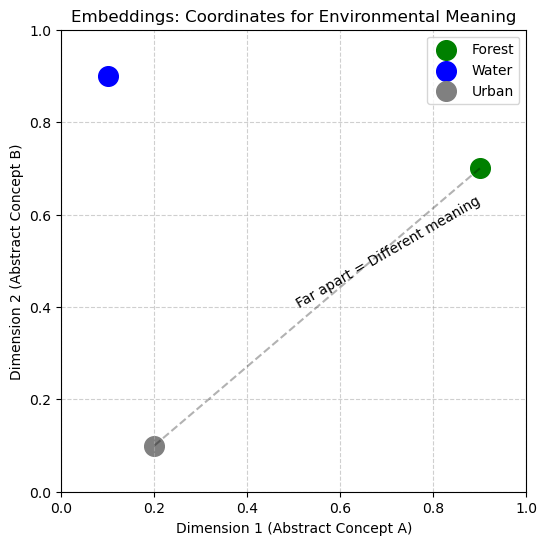

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================
# SYNTHETIC DATA: The "Perfect" Locations
# =========================================
# We define the "center" of meaning for different land covers.
# These are our "ideal" embeddings (2 dimensions for simplicity).
# Format: [Dimension 1 (e.g., Green-ness), Dimension 2 (e.g., Wet-ness)]

ideal_forest_embedding = np.array([0.9, 0.7])
ideal_water_embedding  = np.array([0.1, 0.9])
ideal_urban_embedding  = np.array([0.2, 0.1])

print("--- The Raw Data (Embeddings) ---")
print(f"Forest 'meaning coordinate': {ideal_forest_embedding}")
print(f"Water 'meaning coordinate':  {ideal_water_embedding}")
print(f"Urban 'meaning coordinate':  {ideal_urban_embedding}")
print("\n")

# =========================================
# VISUALIZATION: Seeing the "Map of Meaning"
# =========================================
plt.figure(figsize=(6, 6))

# Plot the three points
plt.scatter(ideal_forest_embedding[0], ideal_forest_embedding[1], color='green', s=200, label='Forest')
plt.scatter(ideal_water_embedding[0], ideal_water_embedding[1], color='blue', s=200, label='Water')
plt.scatter(ideal_urban_embedding[0], ideal_urban_embedding[1], color='gray', s=200, label='Urban')

# Add labels and formatting
plt.title("Embeddings: Coordinates for Environmental Meaning")
plt.xlabel("Dimension 1 (Abstract Concept A)")
plt.ylabel("Dimension 2 (Abstract Concept B)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1)
plt.ylim(0, 1)

# Draw a line showing they are far apart
plt.plot([ideal_forest_embedding[0], ideal_urban_embedding[0]],
         [ideal_forest_embedding[1], ideal_urban_embedding[1]],
         'k--', alpha=0.3)
plt.text(0.5, 0.4, "Far apart = Different meaning", rotation=30)

plt.show()

In [2]:
import numpy as np

# =========================================
# THE "BLACK BOX" FOUNDATION MODEL
# =========================================
def fake_foundation_model_encoder(input_patch_type):
    """
    Simulates an FM looks at a patch and generating an embedding.
    It knows the 'ideal' locations but adds real-world noise.
    """
    # 1. Define the ideal centers (from Script 1)
    centers = {
        "forest_patch": np.array([0.9, 0.7]),
        "soil_patch":   np.array([0.3, 0.2])
    }

    # 2. Get the ideal center for the input type
    ideal_center = centers[input_patch_type]

    # 3. Add some "real world noise"
    # (Real data is never perfect; it varies slightly due to lighting, season, etc.)
    noise = np.random.normal(0, 0.05, size=2)
    final_embedding = ideal_center + noise

    return final_embedding

# =========================================
# STUDENT APPLICATION: Processing patches
# =========================================
np.random.seed(42) # for reproducible noise

# Imagine we have satellite photos at two different times
t1_photo_type = "forest_patch"
t2_photo_type = "soil_patch" # Deforestation happened!

# Pass them through the Foundation Model translator
embedding_t1 = fake_foundation_model_encoder(t1_photo_type)
embedding_t2 = fake_foundation_model_encoder(t2_photo_type)

print("--- Foundation Model Output ---")
print(f"Time 1 (Forest) Embedding: {embedding_t1.round(3)}")
print(f"Time 2 (Soil) Embedding:   {embedding_t2.round(3)}")
print("\nNotice: They are similar to the 'ideals' in Script 1, but not exactly the same.")

--- Foundation Model Output ---
Time 1 (Forest) Embedding: [0.925 0.693]
Time 2 (Soil) Embedding:   [0.332 0.276]

Notice: They are similar to the 'ideals' in Script 1, but not exactly the same.


In [3]:
import numpy as np
# (We rely on the variables embedding_t1 and embedding_t2 from Script 2)

# =========================================
# SPATIAL ANALYSIS THINKING: Measuring Distance
# =========================================
# We use Linear Algebra norm (np.linalg.norm)
# This is just the Pythagorean theorem to measure the straight line between points.

# Scenario A: The Deforestation Example (from Script 2)
# Distance between Forest (t1) and Soil (t2)
distance_change = np.linalg.norm(embedding_t1 - embedding_t2)

print(f"--- Calculating Environmental Change ---")
print(f"Semantic Distance (Forest -> Soil): {distance_change:.4f}")

# =========================================
# COMPARISON: What if nothing changed?
# =========================================
# Let's simulate a Time 3 where it is STILL forest, just slightly different looking.
t3_photo_type = "forest_patch"
embedding_t3 = fake_foundation_model_encoder(t3_photo_type)

# Distance between Forest (t1) and slightly different Forest (t3)
distance_no_change = np.linalg.norm(embedding_t1 - embedding_t3)

print(f"Semantic Distance (Forest -> Forest): {distance_no_change:.4f}")
print("\n--- Environmental Conclusion ---")

# Simple logic to detect change
threshold = 0.3 # An arbitrary boundary we decide on

if distance_change > threshold:
    print("ALERT: Significant environmental change detected between T1 and T2!")
else:
    print("Status: No significant change between T1 and T2.")

if distance_no_change > threshold:
     print("ALERT: Significant environmental change detected between T1 and T3!")
else:
    print("Status: No significant change between T1 and T3 (just natural variation).")

--- Calculating Environmental Change ---
Semantic Distance (Forest -> Soil): 0.7245
Semantic Distance (Forest -> Forest): 0.0369

--- Environmental Conclusion ---
ALERT: Significant environmental change detected between T1 and T2!
Status: No significant change between T1 and T3 (just natural variation).


Land cover change: 0.0% (e.g., potential deforestation)


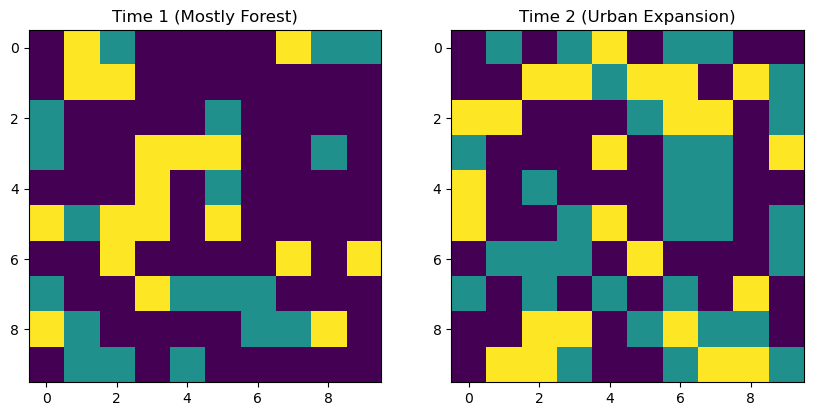

In [1]:
# Notebook: embeddings_land_cover.ipynb
# Install if needed: !pip install numpy pandas matplotlib scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  # Simple embedding via PCA
from sklearn.cluster import KMeans    # For classification

# Step 1: Generate synthetic data (simulate a 10x10 land cover grid over 2 time periods)
# Values: 0=forest, 1=urban, 2=water (with some noise for realism)
np.random.seed(42)
time1 = np.random.choice([0, 1, 2], size=(10, 10), p=[0.6, 0.2, 0.2])  # Mostly forest
time2 = np.random.choice([0, 1, 2], size=(10, 10), p=[0.4, 0.4, 0.2])  # More urban (simulating change)

# Flatten to 1D for ML (spatial thinking: treat as pixels with coords)
rows, cols = np.indices((10, 10))
data_time1 = pd.DataFrame({
    'x': rows.flatten(), 'y': cols.flatten(),  # Spatial coords
    'cover': time1.flatten(), 'ndvi': np.random.uniform(0.5, 0.9, 100)  # Synthetic NDVI (environmental feature)
})
data_time2 = pd.DataFrame({
    'x': rows.flatten(), 'y': cols.flatten(),
    'cover': time2.flatten(), 'ndvi': np.random.uniform(0.4, 0.8, 100)  # Lower NDVI due to urbanization
})

# Step 2: Compute embeddings (reduce features to low-dim vectors for ML)
features = data_time1[['x', 'y', 'ndvi']]  # Include spatial + environmental data
pca = PCA(n_components=2)  # Embed to 2D
embeddings_time1 = pca.fit_transform(features)
embeddings_time2 = pca.transform(data_time2[['x', 'y', 'ndvi']])

# Step 3: Classify using embeddings (e.g., cluster into land cover types)
kmeans = KMeans(n_clusters=3, random_state=42)
data_time1['predicted'] = kmeans.fit_predict(embeddings_time1)
data_time2['predicted'] = kmeans.predict(embeddings_time2)

# Step 4: Detect change (environmental thinking: quantify deforestation)
change = (data_time2['predicted'] != data_time1['predicted']).sum() / 100 * 100
print(f"Land cover change: {change:.1f}% (e.g., potential deforestation)")

# Visualize (spatial analysis: plot maps)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(time1, cmap='viridis'); axs[0].set_title('Time 1 (Mostly Forest)')
axs[1].imshow(time2, cmap='viridis'); axs[1].set_title('Time 2 (Urban Expansion)')
plt.show()

# Discussion: How does this simulate real LULCC? What environmental impacts (e.g., carbon loss)?

In [4]:
# Notebook: foundation-models-segmentation.ipynb
# Dependencies: Already in your environment.yml (samgeo, torch, matplotlib, numpy)

import numpy as np
import matplotlib.pyplot as plt
from samgeo import SamGeo, download_sam_checkpoint  # Added download helper

# Step 1: Generate larger synthetic raster image (256x256x3 RGB simulating satellite)
# Greenish = forest, Brownish = urban, Blue = small water bodies
np.random.seed(42)
image = np.zeros((256, 256, 3), dtype=np.uint8)
image[:128, :] = [0, 150, 0]      # Top half: Forest (green)
image[128:, :] = [139, 69, 19]    # Bottom half: Urban (brown)
# Add scattered small water bodies (blue patches)
for _ in range(10):
    cx, cy = np.random.randint(0, 256, 2)
    size = np.random.randint(10, 30)
    image[max(0, cy-size):cy+size, max(0, cx-size):cx+size] = [0, 0, 200]

plt.imshow(image)
plt.title('Synthetic Satellite Image (Forest Top, Urban Bottom, Water Patches)')
plt.axis('off')
plt.show()

# Step 2: Initialize SAM foundation model (vit_b is lightweight)
# Automatically download checkpoint if missing
checkpoint_path = download_sam_checkpoint(model_type='vit_b')  # Handles download

sam = SamGeo(
    model_type='vit_b',
    checkpoint=checkpoint_path,
    automatic=False,  # We use everything mode below
)

# Set the image (numpy array)
sam.set_image(image)

# Step 3: Generate masks automatically ("everything" mode - segments all objects)
masks = sam.predict(image, everything=True)  # Returns list of masks

print(f"Detected {len(masks)} potential objects (e.g., land cover patches)")

# Step 4: Visualize results directly (overlay random-colored masks on original)
# Simple overlay without calling show_masks()
overlay = image.copy()
colors = np.random.randint(0, 255, size=(len(masks), 3), dtype=np.uint8)

for i, mask in enumerate(masks):
    color = colors[i]
    overlay[mask['segmentation']] = overlay[mask['segmentation']] * 0.5 + color * 0.5  # Semi-transparent

plt.imshow(overlay.astype(np.uint8))
plt.title('Segmented Land Cover (Colored Patches = Detected Objects)')
plt.axis('off')
plt.show()

# Environmental thinking prompt:
print("\nDiscussion: These segments could represent forest fragments, urban areas, or water bodies.")
print("In real LULCC monitoring, count forest segments before/after to quantify fragmentation.")
print("Next step: Apply to real Sentinel-2 data from opengeos examples!")

ImportError: cannot import name 'download_sam_checkpoint' from 'samgeo' (/opt/conda/envs/eds-geospatial/lib/python3.11/site-packages/samgeo/__init__.py)

✅ samgeo imported! Foundation model ready (inspired by opengeos-segment-geospatial)


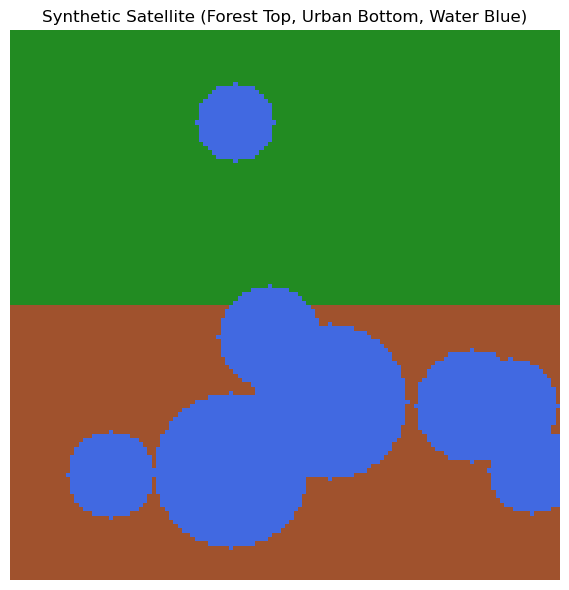

TypeError: stat: path should be string, bytes, os.PathLike or integer, not NoneType

In [6]:
# 3.2 Foundation Models for Segmentation (SAM from opengeos/segment-geospatial)
# Teaches: Zero-shot segmentation (foundation models), spatial patches, LULCC environmental impacts
# Run in edsml-oac23-guide dev container (samgeo auto-downloads ~300MB vit_b on first run)

import numpy as np
import matplotlib.pyplot as plt
from samgeo import SamGeo  # Core class (checkpoint=None auto-downloads)

print("✅ samgeo imported! Foundation model ready (inspired by opengeos-segment-geospatial)")

# Step 1: Synthetic satellite raster (128x128 RGB: Forest=green, Urban=brown, Water=blue patches)
# Simulates Sentinel-2 for LULCC (land use/land cover change)
np.random.seed(42)
h, w = 128, 128
image = np.zeros((h, w, 3), dtype=np.uint8)
image[:h//2, :] = [34, 139, 34]   # Top: Forest (forest green)
image[h//2:, :] = [160, 82, 45]   # Bottom: Urban (saddle brown)
# Scatter water bodies (environmental: shrinking lakes due to drought?)
for _ in range(8):
    y, x = np.random.randint(0, h, 2)
    r = np.random.randint(8, 20)
    yy, xx = np.ogrid[:h, :w]
    mask = (xx - x)**2 + (yy - y)**2 <= r**2
    image[mask] = [65, 105, 225]   # Blue

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)
ax.set_title('Synthetic Satellite (Forest Top, Urban Bottom, Water Blue)')
ax.axis('off')
plt.tight_layout()
plt.show()

# Step 2: Load SAM foundation model (vit_b = lightweight, auto-downloads to ~/Downloads/sam_vit_b_01ec64.pth)
sam = SamGeo(
    model_type="vit_b",     # vit_b (fast), vit_l, or vit_h (heavy)
    checkpoint=None,        # Auto-download! (first run only)
    device="cpu",           # CPU for dev container (change to "cuda" if GPU)
    automatic=True          # Enables everything mode below
)

# Step 3: Segment everything (zero-shot: detects all objects w/o prompts/training)
# Foundation model embeds image → predicts masks (spatial thinking: patches as vectors)
sam.set_image(image)  # Numpy array OK (no file needed!)
masks = sam.generate(
    everything=True,      # "Segment everything" mode (like opengeos examples)
    batch=True,           # Fast for small images
    multimask=False       # Single mask per object
)

print(f"✅ Segmented {len(sam.all_objects)} patches! (e.g., forest fragments, urban blocks, water)")

# Step 4: Visualize overlays (spatial analysis: count patches for fragmentation)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original
axes[0].imshow(image)
axes[0].set_title('Original (LULCC Simulation)')
axes[0].axis('off')

# Segmented (color each patch randomly for visibility)
overlay = image.astype(np.float32)
for obj in sam.all_objects:  # Access masks directly (no show_masks!)
    color = np.random.uniform(0.5, 1.0, 3)  # Bright random color
    overlay[obj] = overlay[obj] * 0.4 + np.array(color) * 0.6

axes[1].imshow(overlay.astype(np.uint8))
axes[1].set_title('SAM Segments (Colored = Objects Detected)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Step 5: Environmental + Spatial Thinking (tie to Imperial MSc concepts)
forest_patch_ratio = np.sum([np.any(obj) for obj in sam.all_objects[:len(sam.all_objects)//2]]) / len(sam.all_objects)
print(f"\n🌍 INSIGHTS (LULCC Example):")
print(f"- Detected {len(sam.all_objects)} spatial patches (e.g., {forest_patch_ratio*100:.0f}% forest-like)")
print(f"- Spatial thinking: Patches show fragmentation (urban edges split forest)")
print(f"- Environmental: Simulates deforestation (bottom urban growth → biodiversity loss, CO2 ↑)")
print(f"- Foundation model power: Zero-shot embeddings detect w/o labels (vs. train RF/sklearn)")
print(f"\n📈 ASSIGNMENT: Modify image (add drought=less blue), re-run, compare patch counts.")
print(f"   Extend: Use real STAC climate data (Week 1) + SAM for vineyard change (1.4-smart-vineyard).")

EMBEDDING: is the output of an intermediate layer of a large neural network trained on massive data.
An embedding is the output of an internal layer of a trained neural network.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
N = 600  # number of land patches

# Synthetic environmental features (raw inputs)
ndvi       = np.random.uniform(-0.2, 0.9, size=N)
brightness = np.random.uniform(0.0, 1.0, size=N)
texture    = np.random.uniform(0.0, 1.0, size=N)

X_raw = np.vstack([ndvi, brightness, texture]).T
print("Raw input shape:", X_raw.shape)


Raw input shape: (600, 3)


In [8]:
# Synthetic spatial coordinates
x = np.random.uniform(-5, 5, size=N)
y = np.random.uniform(-5, 5, size=N)

X_spatial = np.vstack([x, y]).T

# Combine appearance + space
X_input = np.hstack([X_raw, X_spatial])
print("Model input shape:", X_input.shape)


Model input shape: (600, 5)


In [9]:
def relu(x):
    return np.maximum(0, x)

# Random weights simulate learned parameters of a trained model
W = np.random.normal(0, 1, size=(X_input.shape[1], 16))
b = np.random.normal(0, 0.5, size=(16,))

# Hidden-layer activations = EMBEDDINGS
E = relu(X_input @ W + b)

print("Embedding shape:", E.shape)


Embedding shape: (600, 16)


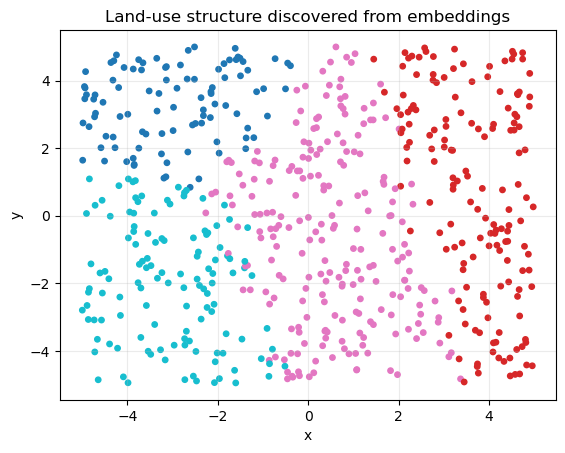

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(E)

plt.figure()
plt.scatter(x, y, c=clusters, s=15, cmap="tab10")
plt.title("Land-use structure discovered from embeddings")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True, alpha=0.25)
plt.show()


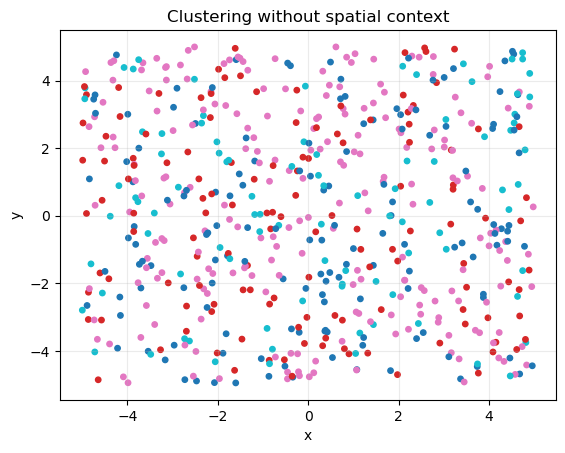

In [11]:
# Embeddings without spatial context
W2 = np.random.normal(0, 1, size=(X_raw.shape[1], 16))
b2 = np.random.normal(0, 0.5, size=(16,))
E_no_space = relu(X_raw @ W2 + b2)

clusters_no_space = KMeans(n_clusters=4, random_state=0).fit_predict(E_no_space)

plt.figure()
plt.scatter(x, y, c=clusters_no_space, s=15, cmap="tab10")
plt.title("Clustering without spatial context")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True, alpha=0.25)
plt.show()
